# Detection of Bruxism events in Tinnitus patients polysomnographic data
This notebook will 
- load EMG channels of polusomnographic data
- detect the EMG bursts in a unsupervised way
- classify EMG bursts as different bruxism events
- give insights on the bruxism events

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mne
import scipy
import seaborn as sns
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.visualization import plotTimeSeries, plotAnnotations, zoom_effect
from tinnsleep.check_impedance import create_annotation_mne, Impedance_thresholding, check_RMS, fuse_with_classif_result
from tinnsleep.scoring import generate_clinical_report
from IPython.core.display import display
from ipywidgets import widgets
print("Config loaded")


Config loaded


## Load, filter, and prepare data

In [20]:
filename = Config.bruxisme_files[1]  # load file from config
picks_chan = ['1', '2']           # subset of EMG electrodes

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
raw  = CreateRaw(raw[picks_chan][0], picks_chan, ch_types=['emg'])        # pick channels and load
raw  = raw.load_data()  # load data into memory 
print("Data loaded")
RAW  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=picks_chan)
ch_names = raw.info["ch_names"]
print("Data filtered")

Extracting EDF parameters from C:\Users\zeta\documents\EEG_polysomno\PSG2\1DA15_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-20-13ad2f7a99a7>:4: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data loaded
Data filtered


## Epoching data

In [21]:
sfreq = raw.info["sfreq"]
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape}")

Epochs done, shape (117720, 2, 50)


## Get the impedance annotations

In [23]:
#Value of the impedance threshold
THR_imp = 6000

raw_imp  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
ch_names = raw_imp.info["ch_names"]
picks_chan = [ch_names[1],ch_names[5]]
print(picks_chan)
#Get the table of bad electrodes booleans from the impedance thresholding algo
check_imp  = Impedance_thresholding(raw_imp[picks_chan][0], picks_chan, duration, interval,THR_imp, ch_types=['emg']) 

print(check_imp)

Extracting EDF parameters from C:\Users\zeta\documents\EEG_polysomno\PSG2\1DA15_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['1 Imp?dance', '2 Imp?dance']


<ipython-input-23-149ef7d48470>:4: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw_imp  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


[[False False]
 [False False]
 [False False]
 ...
 [False  True]
 [False  True]
 [False  True]]


## Classifying epochs and annotate raw

In [24]:
# compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=5)
X        = rms(epochs)
print(len(X))
#Deletes bad epochs and replace bad electrodes values
X        = check_RMS(X, check_imp)
print(len(X))
#Classification on clean datas
labels   = pipeline.fit_predict(X)
print(len(labels))
#Adding back epochs deleted to have the good number of epochs
labels   = fuse_with_classif_result(check_imp, labels)
print(len(labels))


print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length} seconds")

dict_annotations = {1: "burst"}
annotations = []
for k, label in enumerate(labels):
    if label > 0:
        annotations.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations[label],
            origin_time=0.0
        )
            
        )

117720
115841
115841
117720
bursts count: 2427/117720 (2.06%)
bursts time: 606.75 seconds


## Get the clinical report

In [19]:
print(generate_clinical_report(labels))

{'Recording duration': 29430.0, 'Total number of burst': 774, 'Number of bursts per hour': 94.6788990825688, 'Total number of episodes': 126, 'Number of bursts per episode': 6.142857142857143, 'Number of episodes per hour': 15.412844036697248, 'Number of tonic episodes per hour': 1.5902140672782874, 'Number of phasic episodes per hour': 2.232415902140673, 'Number of mixed episodes per hour': 1.2232415902140672, 'Mean duration of tonic episode': 4.5, 'Mean duration of phasic episode': 4.654109589041096, 'Mean duration of mixed episode': 10.0}


## Display Annotations

In [18]:
%matplotlib qt
plt.close("all")
scalings=1e-4
ax1 = plt.subplot(211)
plotTimeSeries(raw.get_data().T, sfreq=raw.info["sfreq"], ax=ax1, scalings=scalings)
plotAnnotations(annotations,color="red")
ax1.set_xlim(5140,5170)
ax2 = plt.subplot(212)
plotTimeSeries(raw.get_data().T, sfreq=raw.info["sfreq"], ax=ax2, scalings=scalings)
zoom_effect(ax1, ax2)

(<mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x15888287518>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnectorPatch at 0x15888287828>)

Traceback (most recent call last):
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 146, in draw_path
    self._renderer.draw_path(gc, path, transform, rgbFace)
OverflowError: In draw_path: Exceeded cell block limit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\backends\backend_qt5.py", line 501, in _draw_idle
    self.draw()
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\figure.py", line 1709, in draw
    renderer, self, artists, self.suppressComposite)
  File "C:\Users\Zeta\Anaconda3\lib\site-packages\matplotlib\image.py", li

In [24]:
# TODO: develop widget
# create widget here
ax1.set_xlim(4000,4500)

(4000, 4500)

In [11]:
import pandas as pd
li=raw["1"][:1000][0][0][1000000:1500000]
df = pd.DataFrame(li,columns=['signal'])


In [12]:
print(len(df)/(200*60))

41.666666666666664


## Affiche les distributions des epochs créés

[-2.00608217e-07  2.00213691e-05  1.06899945e-05  4.65605548e-06
  1.60173096e-06 -1.13411799e-06 -1.73620569e-06 -8.47286955e-07
 -3.01629494e-05  5.58652576e-06  3.75275509e-06  1.09694757e-05
 -1.44962914e-05  1.35149940e-05  1.64941971e-05  4.14249758e-06
  1.78125586e-06 -2.43640206e-05 -2.23338213e-05 -6.47753739e-06
  2.49730145e-05  1.72723958e-05 -4.38680676e-06 -9.03782708e-06
 -1.45529604e-05  2.63344024e-05 -3.10977345e-07 -8.61120387e-06
 -4.69193448e-06 -5.99840609e-06  3.41941148e-06 -6.18304609e-06
 -1.54529570e-08  4.04739442e-06  5.19351202e-06  1.44574300e-05
  2.69855826e-06 -1.43226199e-05 -2.32613199e-05  2.10252994e-05
  1.64684050e-06 -2.74610378e-05  1.82916934e-05  1.09970199e-05
  8.95224202e-07 -8.86698381e-06  9.96484303e-06 -6.10841812e-06
  7.44437757e-06 -3.02686238e-05  3.95818930e-06]


RuntimeError: Since bad epochs have not been dropped, the length of the Epochs is not known. Load the Epochs with preload=True, or call Epochs.drop_bad(). To find the number of events in the Epochs, use len(Epochs.events).

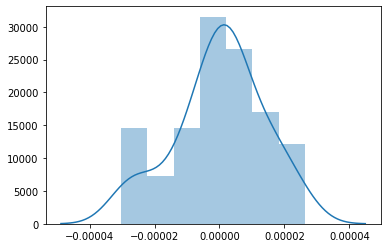

<Figure size 432x288 with 0 Axes>

In [14]:
print(epochs[0].get_data()[0][0])
plt.figure()
sns.distplot(Epo[0].get_data()[0][0])

plt.figure()
print(int(len(Epo)/100))
for i in range(int(len(Epo)/100)):
    sns.distplot(Epo[100*i].get_data()[0][0])

## Créé les transformées de Fourier (Welch) des epochs et récupère les coefficients entre 20 et 100 Hz

In [ ]:
#Epo.plot(scalings = 'auto', n_channels = 3)
def Extract_Alpha(E):
        AP = []
        print (len(E))
        flag = 0
        for epoch in E:

            #print len(epoch[0])

            #Il se passe des choses bizarres ici !! 

            FFTBIS = scipy.signal.welch(epoch, fs=200.0, window='hanning')
            if flag == 0 :
                print (len(epoch))
                print (FFTBIS[0][20:100])
                print (len(FFTBIS[0]))
                flag = 1
            ap = 0
            
            ap=FFTBIS[1][0][20:100]    #seulement la channel 1, de 20Hz à 50Hz
            
            AP.append(ap)


        return(AP)

get_al=Extract_Alpha(Epo)
print(get_al[:10])

## Affiche l'ensemble des FFTs précedemment calculées

In [ ]:
plt.figure()
print(int(len(get_al)/100))
for i in range(int(len(get_al)/100)):
    plt.plot(get_al[100*i])